# 技能练度截图计算工具 (草稿)

## 环境

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import measure

## 0. 必要函数定义

In [2]:
# 定义图像之间差别
def image_diff(im_1, im_2, mask=None):
    """
    Variables
    ---------
    
    im_1, im_2: np.array
        Two images that need to be compared
    
    mask: np.array
        Mask on two images
        `Zero' or `False' value in mask means that we don't compare `im_1' and `im_2' at these pixels
    
    Note
    ----
    
    Shape of `im_1', `im_2', `mask' should be the same
    """
    if im_1.shape != im_2.shape: im_1 - im_2  # raise error here
    if mask is None:
        mask = np.zeros(im_1.shape) + 1
    return (np.abs((im_1 - im_2) * mask)).sum() / mask.sum()

In [3]:
# 寻找一条线上，低于阈值的部分的局域极小值在列表中的位置
def find_lmin(line, thresh=None):
    """
    Variables
    ---------
    
    line: np.array
        the line we want to find the local minimun
    
    thresh: float
        we just account the area that the line under than thresh
    
    Note
    ----
    
    All values in `line' should be larger than zero
    as well as `line' should be float and be acceptable for np.nan
    """
    if thresh is None: thresh = np.max(line)
    lmin = []
    line_mask = np.array(line<thresh, dtype=float)
    for i in range(len(line_mask)):
        if line_mask[i] == 0.: line_mask[i] = np.nan
    line_under_thresh = line * line_mask
    for i in range(2,len(line_under_thresh)-2):
        if (line_under_thresh[i] < line_under_thresh[i-1]) \
            and (line_under_thresh[i] < line_under_thresh[i+1]):
            lmin.append(i)
        elif line_under_thresh[i] == line_under_thresh[i]:  # include only one or two points under threshold; if two points, return the smaller one
            if not (line_under_thresh[i-1] == line_under_thresh[i-1]) and not (line_under_thresh[i+1] == line_under_thresh[i+1]):  # one point
                lmin.append(i)
            elif not (line_under_thresh[i-1] == line_under_thresh[i-1]) and not (line_under_thresh[i+2] == line_under_thresh[i+2]):  # nabn
                if line_under_thresh[i] <= line_under_thresh[i+1]: lmin.append(i)
            elif not (line_under_thresh[i+1] == line_under_thresh[i+1]) and not (line_under_thresh[i-2] == line_under_thresh[i-2]):  # nban
                if line_under_thresh[i] < line_under_thresh[i-1]: lmin.append(i)
    return lmin

## 1. 从者位置确定

### 1.1 首先要把我们要考察的图片，以及可以定位从者信息的图片读入

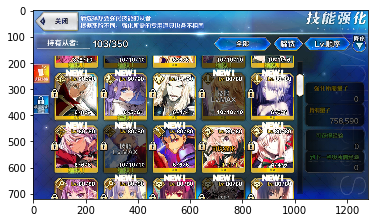

In [4]:
# 要考察的图片
# -- Note: 这里统一使用 16:9 大小的图片，否则报错
# -- Note: 必须是横屏截图，上下一致
im_skill = plt.imread("database/skill/skill_3.png")[:,:,:3]
if im_skill.shape[0] / im_skill.shape[1] != 0.5625:
    raise ValueError("Please import figures correctly!")
im_skill = resize(im_skill, (720,1280), mode="reflect")
plt.imshow(im_skill)

(19, 158, 3)


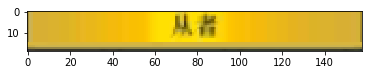

In [5]:
# 定位从者位置的图片
# -- Note: 这里统一会换成 720 像素大小
im_servant_indicator_gold = plt.imread("database/servant_indicator/gold.png")[:,:,:3]
plt.imshow(im_servant_indicator_gold)
print(im_servant_indicator_gold.shape)

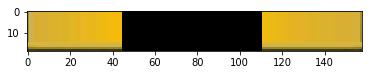

In [6]:
# 确定这次的遮罩
# 之所以需要定义遮罩，是因为在中央会出现绿色的“编队!”字样
im_servant_indicator_mask = np.zeros(im_servant_indicator_gold.shape)
im_servant_indicator_mask[:,:45,:] += 1
im_servant_indicator_mask[:,111:,:] += 1
plt.imshow(im_servant_indicator_gold * im_servant_indicator_mask)

### 1.2 通过手算几个例子确定阈值大小

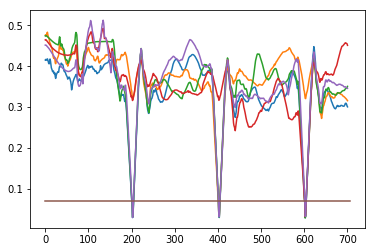

In [7]:
# 这个过程也是人工的，但应该泛用
# 首先人工应当能判断在 ([86, 274, 461, 649, 836], *) 附近一般有从者的标记
# -- Conclusion: 阈值取在 0.07 是合适的
row_estimate = [86, 274, 461, 649, 836]
col_index = range(720-19)
col_diff = [np.array([image_diff(im_skill[i:i+19, j:j+158, :], im_servant_indicator_gold, \
                                 im_servant_indicator_mask) for i in col_index ])
            for j in row_estimate ]
for i in range(5):
    plt.plot(col_index, col_diff[i])
plt.plot([0,705], [0.07,0.07])

In [8]:
# 现在就可以确定到底目前有多少从者，以及在哪些位置了
# 一切的假定是横向坐标在 [86, 274, 461, 649, 836] 附近
# 以及，如果纵坐标小于 309，那么尽管我们能认出这是从者，但信息不够完全；因此把纵向 309 以下的坐标完全忽略
servant_location = []
col_estimate = np.array([86, 274, 461, 649, 836])
row_index = range(309,720-19)
for i in col_estimate:
    col_diff = np.array([image_diff(im_skill[j:j+19, i:i+158, :], im_servant_indicator_gold, \
                                    im_servant_indicator_mask) for j in row_index ])
    col_lmin = find_lmin(col_diff, 0.11)
    for j in col_lmin:
        servant_location.append([i, j+309])
servant_location

[[86, 403],
 [86, 602],
 [274, 402],
 [461, 403],
 [461, 602],
 [649, 602],
 [836, 403],
 [836, 602]]

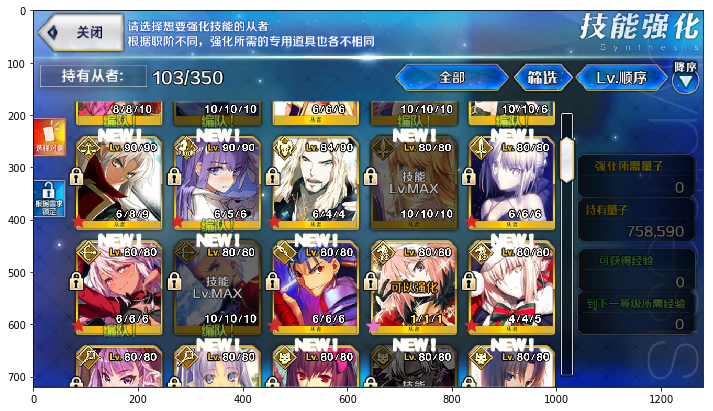

In [9]:
# 借由下图可以看到我们寻找到的从者的位置了
# 红色五角星就是标记的位置
# 阿福是粉色的，嗯 >.<
axs, fig = plt.subplots(figsize=(12,20))
plt.plot(np.array(servant_location).T[0], np.array(servant_location).T[1], \
         color="C3", marker="*", markersize=15, linestyle="None")
plt.plot([649], [603], \
         color="C6", marker="*", markersize=15, linestyle="None")
fig.imshow(im_skill)

### 1.3 完整实现

10


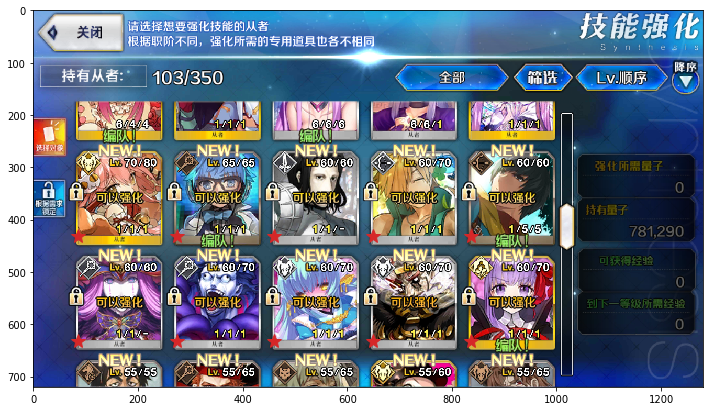

In [10]:
# 我们取一副新的图，包含金、银、铜卡
# 1. 读图
# -- Hand: 下一行的数据需要用户自己设定
skill_path = "database/skill/skill_5.png"
# -- Hand Over
im_skill = plt.imread(skill_path)[:,:,:3]
if im_skill.shape[0] / im_skill.shape[1] != 0.5625:
    raise ValueError("Please import figures correctly!")
im_skill = resize(im_skill, (720,1280), mode="reflect")
# 2. 读定位标记
im_servant_indicator = []
im_servant_indicator.append(plt.imread("database/servant_indicator/gold.png")[:,:,:3])
im_servant_indicator.append(plt.imread("database/servant_indicator/silver.png")[:,:,:3])
im_servant_indicator.append(plt.imread("database/servant_indicator/bronze.png")[:,:,:3])
im_servant_indicator_mask = np.zeros(im_servant_indicator[0].shape)
im_servant_indicator_mask[:,:45,:] += 1
im_servant_indicator_mask[:,111:,:] += 1
# 3. 定位
servant_location = []
col_estimate = np.array([86, 274, 461, 649, 836])
row_index = range(309,720-19)
for i in col_estimate:
    for rarity in range(3):
        col_diff = np.array([image_diff(im_skill[j:j+19, i:i+158, :], im_servant_indicator[rarity], \
                                        im_servant_indicator_mask) for j in row_index ])
        col_lmin = find_lmin(col_diff, 0.07)
        for j in col_lmin:
            servant_location.append([i, j+309])
# 绘制结果
axs, fig = plt.subplots(figsize=(12,20))
plt.plot(np.array(servant_location).T[0], np.array(servant_location).T[1], \
         color="C3", marker="*", markersize=15, linestyle="None")
fig.imshow(im_skill)
print(len(servant_location))

## 2. 从者识别

### 2.1 确定被识别对象大小与遮罩

在刚才的图片中，阿斯托尔福是最典型的例子：他的头像上被掩盖的障碍物最多．
如果我们有标准的阿斯托尔福图片，我们必然不希望标准图与我们截图中的文字比对；
因此，我们干脆做一个遮罩，把那些文字去除掉．

(130, 156, 3)


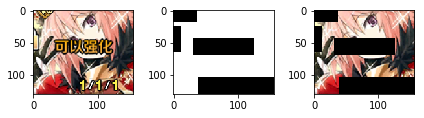

In [11]:
# 英灵标准头像；遮罩；遮罩后的英灵标准头像的示意图
# -- Note: 等到将来有数据库了，英灵头像应该要可以统一设置
im_servant_full = plt.imread("database/servant_mask/full.png")[:,:,:3]
im_servant_mask = plt.imread("database/servant_mask/mask.png")[:,:,:3]
im_servant_masked = im_servant_full * im_servant_mask
print(im_servant_full.shape)
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
plt.imshow(im_servant_full)
ax = fig.add_subplot(1, 3, 2)
plt.imshow(im_servant_mask)
ax = fig.add_subplot(1, 3, 3)
plt.imshow(im_servant_masked)
fig.tight_layout()

### 2.2 从数据库确定从者信息

我的数据库的构建方式就是上一节的方法，在`个人空间`→`卡牌图鉴`→`灵基一览`截图，确定从者位置

然后在从者位置右上方一个像素的位置上，开始截图 (156\*130) 大小

因此这个数据库明显地有问题

因为从者头像除了活动送的从者之外，至少有四种形态

以及特例安哥拉曼纽不是金银铜卡，所以他的信息没有录进去

所以就将就着用吧……

我们现在就拿阿福看看他是几号从者；现在国服实装 168 骑

In [12]:
servant_score = np.zeros(168)
for servant_ind in range(168):
    try:
        # since my database is RGBA; however we only want RGB, so truncate the 4th row of RGBA
        im_database = plt.imread("database/servant_database/" + "{:03d}".format(servant_ind) + ".png")[:,:,:3]
        servant_score[servant_ind] = image_diff(im_servant_full, im_database, mask=im_servant_mask)
    except:
        servant_score[servant_ind] = np.nan

0.0669727697968483
94


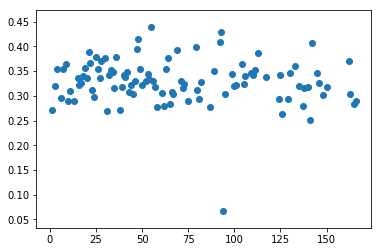

In [13]:
plt.scatter(np.arange(168), servant_score)
print(np.nanmin(servant_score))
print(np.nanargmin(servant_score))

### 2.3 完整实现

{58: {'location': [86, 431]}, 35: {'location': [86, 631]}, 32: {'location': [274, 631]}, 33: {'location': [274, 431]}, 9: {'location': [461, 431]}, 56: {'location': [461, 631]}, 13: {'location': [649, 431]}, 49: {'location': [649, 631]}, 166: {'location': [836, 631]}, 16: {'location': [836, 431]}}


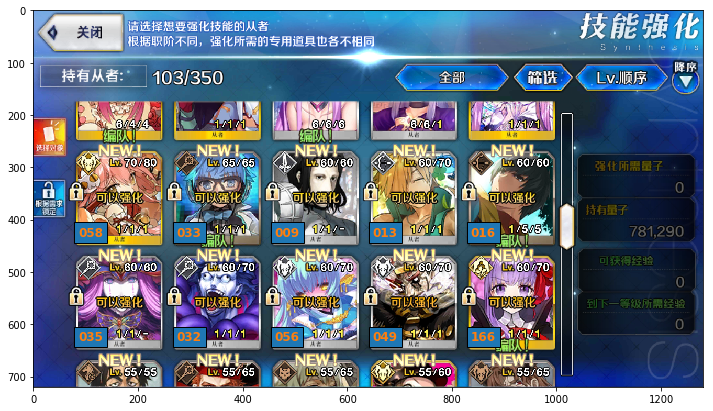

In [14]:
# 现在我们已经有了 im_skill 与 servant_location 信息了
# 字典 servent_dict 是你现在有的从者的所有信息
servant_dict = {}
im_servant_mask = plt.imread("database/servant_mask/mask.png")[:,:,:3]
for servant_loc in servant_location:
    servant_score = np.zeros(168)
    loc_row = servant_loc[1]; loc_col = servant_loc[0]
    im_servant_full = im_skill[loc_row-131:loc_row-1, loc_col+1:loc_col+157, :]
    for servant_ind in range(168):
        try:
            # since my database is RGBA; however we only want RGB, so truncate the 4th row of RGBA
            im_database = plt.imread("database/servant_database/" + "{:03d}".format(servant_ind) + ".png")[:,:,:3]
            servant_score[servant_ind] = image_diff(im_servant_full, im_database, mask=im_servant_mask)
        except:
            servant_score[servant_ind] = np.nan
    servant_ind = np.nanargmin(servant_score)
    servant_dict[servant_ind] = {}
    servant_dict[servant_ind]["location"] = servant_loc
# 绘制结果
axs, fig = plt.subplots(figsize=(12,20))
for servant_ind in servant_dict:
    plt.text(servant_dict[servant_ind]["location"][0], servant_dict[servant_ind]["location"][1], "{:03d}".format(servant_ind), \
             color="C1", weight="bold", bbox=dict(facecolor='C0'), fontsize=12)
fig.imshow(im_skill)
print(servant_dict)

## 3. 读取技能练度

### 3.1 技能练度数字与斜杠示意

这部分工作就是手动提取了……

之后所有的图像，都会经过最简单的大小为 128 的二值化处理，以清晰地确定数字的位置；

同时避免数字中间黄色的图像与白色图像的区别，阈值处理我想应该是得当的

In [15]:
# 数字二值处理，而这些数值的 png 图片的 alpha 通道是有用的，它规定了数值的 mask
im_number = []
im_number_mask = []
for i in range(10):
    im_tmp = plt.imread("database/numbers/" + "{:1d}".format(i) + ".png")
    im_number.append(im_tmp[:,:,0])
    im_number_mask.append(im_tmp[:,:,3])
im_tmp = plt.imread("database/numbers/slash.png")
im_number.append(im_tmp[:,:,0])
im_number_mask.append(im_tmp[:,:,3])

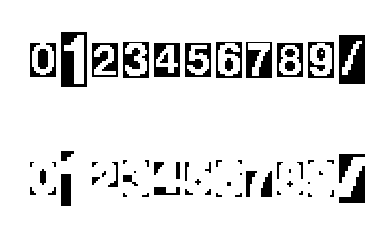

In [16]:
# 都是 17 像素高的，matplotlib 是抽风了么……
fig = plt.figure()
plt.axis('off')
for i in range(11):
    fig.add_subplot(2,11,i+1)
    plt.axis('off')
    plt.imshow(im_number[i]*im_number_mask[i], cmap="gray")
    fig.add_subplot(2,11,12+i)
    plt.axis('off')
    plt.imshow(im_number_mask[i], cmap="gray")

### 3.2 从图像读出单连通区域

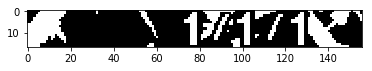

In [17]:
# 还是拿阿福的举例子
# 数字统一认为是 17 像素高，因此我们抽取这 17 像素并对图像作二值化
im_astolfo_skill = rgb2gray(plt.imread("database/servant_mask/full.png")[108:125,:,:]) > 0.5
plt.imshow(im_astolfo_skill, cmap='gray')

下一步我们将要提取连通区域，并对连通区域作标签．

In [18]:
im_astolfo_skill_labels = measure.label(im_astolfo_skill, background=0)

第一步：需要确定数字的位置

数字一般都有至少以下特征：
* 横向的像素数 6~11
* 纵向的像素数 14~16

为此，我们需要确定每个连通区域的大小

In [19]:
def connect_area(mat, value):
    mat_bin = (mat == value)
    row_lower, row_upper, col_lower, col_upper = None, mat.shape[0]-1, None, mat.shape[1]-1
    for i in range(mat.shape[0]):
        if row_lower is None and mat_bin[i,:].any():
            row_lower = i
        if row_lower is not None and not mat_bin[i,:].any():
            row_upper = i-1
            break
    for i in range(mat.shape[1]):
        if col_lower is None and mat_bin[:,i].any():
            col_lower = i
        if col_lower is not None and not mat_bin[:,i].any():
            col_upper = i-1
            break
    if row_lower is None or col_lower is None:
        raise ValueError("Matrix imput contains no value required")
    return row_lower, row_upper, col_lower, col_upper

In [20]:
for i in range(1, im_astolfo_skill_labels.max()+1):
    row_lower, row_upper, col_lower, col_upper = connect_area(im_astolfo_skill_labels, i)
    if (5 <= (col_upper - col_lower + 1) <= 12) and (14 <= (row_upper - row_lower + 1) <= 17):
        print(i)

9
10
11


因此，可以判断 9/10/11 标记上的连通区域应当是数字．

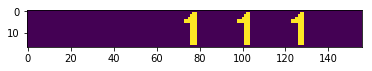

In [21]:
plt.imshow((im_astolfo_skill_labels==9)*1 + (im_astolfo_skill_labels==10)*1 + (im_astolfo_skill_labels==11)*1)

尽管可能有外界信息干扰；但一般来说这就足够了．斜杠与横杠按这种方法一般是读不进来的．

### 3.3 数字或字符位置确定

随后我们就需要进行模式判断．我们需要通过数字在图像位置上的分布来分割数字．

由于这些数字与字符都是等宽字符，因此可以通过数字的位置确定练度模式．下面为参考的数字中轴位置：
* 奇数模式：1/1/1, 10/10/1 等 4 种：`[(65), 77, 90, 102, 115, 127, (140)]`
* 偶数模式：10/1/1, 10/10/10 等 4 种 `[71, 83, 96, 108, 121, 133]`

在从者的识别上，原则上，不可能识别出技能等级满的从者，因此 10/10/10 情况不可能发生

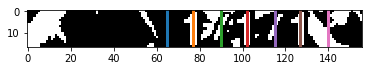

In [22]:
im_astolfo_skill = rgb2gray(plt.imread("database/servant_mask/full.png")[108:125,:,:]) > 0.5
plt.imshow(im_astolfo_skill, cmap='gray')
for i in [65, 77, 90, 102, 115, 127, 140]:
    plt.plot([i,i],[0,16], linewidth=3)

In [23]:
# 确定练度模式
# 首先，我们要给出连通区域的中值位置
# 将来所有的数字有关的信息，将会储存在 im_astolfo_skill_label_dict 字典中
im_astolfo_skill_label_dict = {}
im_astolfo_skill_label_dict["label"] = {}
for i in range(1, im_astolfo_skill_labels.max()+1):
    row_lower, row_upper, col_lower, col_upper = connect_area(im_astolfo_skill_labels, i)
    if (5 <= (col_upper - col_lower + 1) <= 12) and (14 <= (row_upper - row_lower + 1) <= 16):
        im_astolfo_skill_label_dict["label"][i] = {}
        im_astolfo_skill_label_dict["label"][i]["boundary"] = (row_lower, row_upper, col_lower, col_upper)
        im_astolfo_skill_label_dict["label"][i]["center"] = (col_upper + col_lower) / 2
# 首先要预判断是否存在明显不合理的单连通区域
# 这段代码有问题，会报 RuntimeError: dictionary changed size during iteration
# 在字典的循环里，不允许更改字典大小
# 所以在真正实际执行的时候要改掉
for i, j in im_astolfo_skill_label_dict["label"].items():
    if j["center"] <= 55 or j["center"] >= 143:
        im_astolfo_skill_label_dict["label"].pop(i)
# 随后先判断模式种类
label_odd = np.array([65, 77, 90, 102, 115, 127, 140])
label_even = np.array([71, 83, 96, 108, 121, 133])
if np.array([ np.abs(label_odd-i["center"]).min() for _, i in im_astolfo_skill_label_dict["label"].items() ]).sum() \
    < np.array([ np.abs(label_even-i["center"]).min() for _, i in im_astolfo_skill_label_dict["label"].items() ]).sum():
    im_astolfo_skill_label_dict["mode"] = "odd"
    label_mode = label_odd
else:
    im_astolfo_skill_label_dict["mode"] = "even"
    label_mode = label_even
im_astolfo_skill_label_dict

{'label': {9: {'boundary': (1, 15, 73, 78), 'center': 75.5},
  10: {'boundary': (1, 15, 98, 103), 'center': 100.5},
  11: {'boundary': (1, 15, 123, 128), 'center': 125.5}},
 'mode': 'odd'}

确定好模式后，我们给每个单连通区域填充其位置信息；如果有比较不符合现有模式的单连通区域，剔除之．

In [24]:
# 这段代码有问题，会报 RuntimeError: dictionary changed size during iteration
# 在字典的循环里，不允许更改字典大小
# 所以在真正实际执行的时候要改掉
for i, j in im_astolfo_skill_label_dict["label"].items():
    if np.abs(label_mode-j["center"]).min() >= 3:
        im_astolfo_skill_label_dict["label"].pop(i)
        continue
    im_astolfo_skill_label_dict["label"][i]["location"] = np.abs(label_mode-j["center"]).argmin()

In [25]:
im_astolfo_skill_label_dict

{'label': {9: {'boundary': (1, 15, 73, 78), 'center': 75.5, 'location': 1},
  10: {'boundary': (1, 15, 98, 103), 'center': 100.5, 'location': 3},
  11: {'boundary': (1, 15, 123, 128), 'center': 125.5, 'location': 5}},
 'mode': 'odd'}

### 3.4 数字识别

数字识别就跟以前一样了．我们拿我们既有的数字数据库来做这件事．

在我们所识别的数字左边界附近，将数字与数据库中的数字相比较；如果比较下来的误差很小，那么我们认为我们识别出了数字．

与之前不同的是，这次不需要使用遮罩．然而数据库中的数字遮罩部分是白色的；因此使用这些数字之前，需要经过简单的预处理．

In [26]:
for i, j in im_astolfo_skill_label_dict["label"].items():
    number_compare_score = np.zeros(10)  # score of the number likewise
    for number in range(10):
        number_diff = []
        for pixel_left in range(j["boundary"][2]-3, j["boundary"][2]+2):
            number_diff.append( \
                image_diff(im_astolfo_skill_labels[:, pixel_left:pixel_left+im_number[number].shape[1]]==i, \
                           im_number[number] * im_number_mask[number]) \
            )
        number_compare_score[number] = np.array(number_diff).min()
    if number_compare_score.min() > 0.25:  # probably not a number, perhaps slash; delete from dictionary
        # 这段代码有问题，会报 RuntimeError: dictionary changed size during iteration
        # 在字典的循环里，不允许更改字典大小
        # 所以在真正实际执行的时候要改掉
        im_astolfo_skill_label_dict["label"].pop(i)
        continue
    # return the recognized number back to dictionary
    im_astolfo_skill_label_dict["label"][i]["number"] = number_compare_score.argmin()
    im_astolfo_skill_label_dict["label"][i]["number_str"] = "{:1d}".format(number_compare_score.argmin())
im_astolfo_skill_label_dict

{'label': {9: {'boundary': (1, 15, 73, 78),
   'center': 75.5,
   'location': 1,
   'number': 1,
   'number_str': '1'},
  10: {'boundary': (1, 15, 98, 103),
   'center': 100.5,
   'location': 3,
   'number': 1,
   'number_str': '1'},
  11: {'boundary': (1, 15, 123, 128),
   'center': 125.5,
   'location': 5,
   'number': 1,
   'number_str': '1'}},
 'mode': 'odd'}

实际上的技能练度识别会复杂一些，因为会无法区别 5, 6, 8, 9 四个数字．

在实际执行数字识别的时候，会通过连通区域的大小来判断数字．

### 3.5 技能等级最终确定

最后，我们根据我们所确定的数的分布情况，确定最终的技能等级．

如果技能等级小于 3 的，我们要补上 `None` 表示英灵很可能没有该技能．

In [27]:
im_astolfo_skill_list = [" "] * len(label_mode)
for i, j in im_astolfo_skill_label_dict["label"].items():
    im_astolfo_skill_list[j["location"]] = j["number_str"]
im_astolfo_skill_finalize = [ int(i) for i in "".join(im_astolfo_skill_list).split() ]
im_astolfo_skill_finalize

[1, 1, 1]